In [1]:
import numpy as np
import stim

In [2]:
def sparse_compress(sample):
    non_zero_idx = np.where(sample)[0]
    g_addr_len = len(sample).bit_length()
    bit_vector = np.zeros(len(non_zero_idx) * g_addr_len, dtype=bool)
    for i, index in enumerate(non_zero_idx):
        bit_vector[g_addr_len*i:g_addr_len*(i+1)] = np.array([b == '1' for b in np.base_repr(index, 2, padding=g_addr_len - int(index).bit_length())], dtype=bool)
    return bit_vector

In [3]:
p = 1e-3

def estimate_power(bandwidth):
    # Per cable - 10 gbps
    #           - 31 mW
    num_cables = np.ceil(bandwidth / 1)
    return num_cables * 31 # mW

def sim(d, L, num_samples):
    # d - code distance
    # L - number surface codes
    circ = stim.Circuit.generated("surface_code:rotated_memory_z", distance=d, rounds=2, 
                                after_clifford_depolarization=p, 
                                before_measure_flip_probability=p, 
                                after_reset_flip_probability=p)

    sampler = circ.detector_error_model().compile_sampler()
    det_coords = circ.get_detector_coordinates()
    samples = sampler.sample(num_samples, return_errors=True)

    round_0_dets = []
    for det, coords_2x in det_coords.items():
        if coords_2x[2] == 0:
            round_0_dets.append(det)
            continue

    round_0_errors = []
    for i, err in enumerate(circ.detector_error_model()):
        if err.type == 'error':
            for det in err.targets_copy():
                if det.is_relative_detector_id() and det_coords[det.val][2] == 0:
                    round_0_errors.append(i)
                    break

    det_samples = samples[0][:,len(round_0_dets):]
    err_samples = samples[2][:,len(round_0_errors):]

    results = { # Optimizations are cumulative e.g. PFU includes cryo control
        'naive': [0,0],
        'cryo_control': [0,0],
        'PFU': [0,0],
        'band_reduce': [0,0]
    }

    for i in range(num_samples):
        dets = det_samples[i]
        errs = err_samples[i]

        gates = d ** 2 * 16 * np.log2(d ** 2) # d^2 ancilla with 4 CX gates and 2 H. Qubit address is log_2(d^2)
        controls = np.count_nonzero(errs) * 2 * np.log2(d ** 2)# Controls for physical corrections X/Z w/ log_2(d^2) address (no PFU)
        full_syndrome = len(dets)
        sparse_syndrome = len(sparse_compress(dets))

        naive_bandwidth = (L * (gates + controls) * 1e-3, L * full_syndrome * 1e-3) # Gbps
        cryo_bandwidth = (L * (controls) * 1e-3, L * full_syndrome * 1e-3)
        PFU_bandwidth = (0, L * (full_syndrome) * 1e-3)
        band_reduce_bandwidth = (0, L * (sparse_syndrome) * 1e-3)


        results['naive'][0] += (naive_bandwidth[0] + naive_bandwidth[1]) / num_samples
        results['naive'][1] += (estimate_power(naive_bandwidth[0]) + estimate_power(naive_bandwidth[1])) / num_samples
                                   
        results['cryo_control'][0] += (cryo_bandwidth[0] + cryo_bandwidth[1]) / num_samples
        results['cryo_control'][1] += (estimate_power(cryo_bandwidth[0]) + estimate_power(cryo_bandwidth[1])) / num_samples

        results['PFU'][0] += (PFU_bandwidth[0] + PFU_bandwidth[1]) / num_samples
        results['PFU'][1] += (estimate_power(PFU_bandwidth[0]) + estimate_power(PFU_bandwidth[1])) / num_samples

        results['band_reduce'][0] += (band_reduce_bandwidth[0] + band_reduce_bandwidth[1]) / num_samples
        results['band_reduce'][1] += (estimate_power(band_reduce_bandwidth[0]) + estimate_power(band_reduce_bandwidth[1])) / num_samples
    

    return results


In [4]:
d = 21
num_samples = 1_000
L_range = 2 * np.arange(1, 51)
d_range = [9, 13, 17, 21, 25, 29]
results = {}

for d in d_range:
    for L in L_range:
        results[(d,L)] = sim(d, L, num_samples)

### Plotting

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

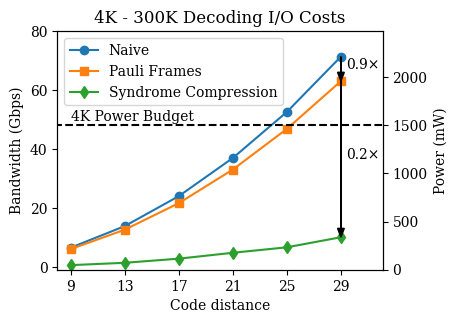

In [6]:
fig, ax1 = plt.subplots(figsize=(4.2,3.1))
ax2 = ax1.twinx() 

ax1.plot(d_range, [results[(d,50)]['cryo_control'][0] for d in d_range], color="tab:blue",marker='o', label='Naive')
ax1.plot(d_range, [results[(d,50)]['PFU'][0] for d in d_range], color="tab:orange",marker='s', label='Pauli Frames')
ax1.plot(d_range, [results[(d,50)]['band_reduce'][0] for d in d_range], color="tab:green",marker='d', label='Syndrome Compression')

ax2.plot(np.arange(-5, 35), [1500 for i in np.arange(-5, 35)], color='black', linestyle='dashed')
ax2.text(9, 1550, '4K Power Budget', color='black')

ax1.arrow(29, results[29,50]['cryo_control'][0], 0, results[29,50]['PFU'][0] - results[29,50]['cryo_control'][0], 
          length_includes_head=True, head_width=0.5, head_length=3, zorder=5, color='black')
ax1.text(29.4, (results[29,50]['cryo_control'][0] + results[29,50]['PFU'][0])/2, 
         f"{(results[29,50]['PFU'][0] / results[29,50]['cryo_control'][0]):.1f}×")
ax1.arrow(29, results[29,50]['PFU'][0], 0, results[29,50]['band_reduce'][0] - results[29,50]['PFU'][0], 
          length_includes_head=True, head_width=0.5, head_length=3, zorder=5, color='black')
ax1.text(29.4, (results[29,50]['PFU'][0] + results[29,50]['band_reduce'][0])/2, 
         f"{(results[29,50]['band_reduce'][0] / results[29,50]['PFU'][0]):.1f}×")


plt.xticks(d_range, [str(L) for L in d_range])
plt.xlim(8, 32.1)

ax1.set_ylim(-1, 80)
ax2.set_ylim(-1, 80 * 31)

ax1.set_ylabel('Bandwidth (Gbps)')
ax1.set_xlabel('Code distance')
ax2.set_ylabel('Power (mW)')
ax1.legend(loc='upper left')
plt.title('4K - 300K Decoding I/O Costs')
plt.savefig('figures/bandwidth_power.pdf', bbox_inches='tight')